# Analisis de variables 

En este cuaderno se explora que variables se tienen, esto con el objetivo de poder identificar modelo que se ajusten a las necesidades de predicción. En primer lugar se hace la carga de datos desde un archivo binario que se obtiene de una petición SQL hecha anteriormente

In [2]:
import pickle5 as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [3]:
filename = "data.ftr"

with open(filename, "rb") as fh:
    data = pickle.load(fh)
    
data = pd.DataFrame(data)

## Construcción de serie temporal binaria

Para hacer una predicción inicial del modelo se pretende adoptar la columna de datos de __FECHA PAGO__ y convertirla en una serie binaria, para de esta manera tratar de hacer una predicción a futuro de la fecha de pago. 

Veamos como se distribuye el pago de un producto a través del tiempo, para esto se construye una función del tiempo que permita ver el comportamiento , veamos cuantos productos se tiene en la base de datos 

In [4]:
n_products = len(data["ID_CONTRATO"].value_counts())
print("Numero de productos existentes en la base de datos = {}".format(n_products))

Numero de productos existentes en la base de datos = 7230


Para poder hacer un estudio se elige un producto al azar de los encontrados anteriormente

In [5]:
producto_x = data["ID_CONTRATO"].value_counts().index[10]
print("Producto seleccionado = {}".format(producto_x))

Producto seleccionado = 9556.0


Se hace un filtro por producto para elegir las fechas en las cual se tiene el pago del producto seleccionado 

In [6]:
fecha_pago = data["FECHA_PAGO"][data["ID_CONTRATO"]==producto_x]
fecha_pago = pd.to_datetime(fecha_pago)
fecha_pago

2363     2020-04-01
2746     2018-11-24
6554     2019-03-27
11726    2019-05-27
12080    2019-06-29
            ...    
163825   2019-02-23
170998   2019-10-29
175686   2020-01-29
181863   2014-03-03
182549   2012-12-05
Name: FECHA_PAGO, Length: 94, dtype: datetime64[ns]

Para ver como es el comportamiento de pago se hace una linea de tiempo y anotar con in indicar en el momento en el que el cliente realiza el pago 

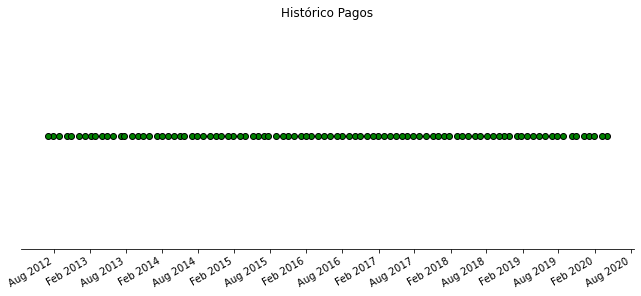

In [7]:
name_pay = ["pago "+str(i) for i in range(1, len(fecha_pago))]
levels = np.tile([5], int(np.ceil(len(fecha_pago)/6)))[:len(fecha_pago)]

# Create figure
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
# put title
ax.set(title="Histórico Pagos")
ax.plot(fecha_pago, np.zeros_like(fecha_pago), "ro",
        color="k", markerfacecolor="g")  

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)




La intención del programa será predecir en que fecha se realizará el siguiente pago, en simples terminos, en que momento del tiempo se ubicará el siguiente punto verde. Sin embargo aún faltan anotar todas las fechas completas para conmesurar y tener los datos de cada cuanto se hace el pago. Se crea un vector que contenga todos lops días desde el inicio del primer pago, hasta el ultimo registrado 

In [8]:
first_pay = fecha_pago.min()
last_pay  = fecha_pago.max() 
time_product = pd.date_range(first_pay, last_pay)
print("Dias de vida del producto = {}".format(len(time_product)))
print("Pago hechos = {}".format(len(fecha_pago)))

Dias de vida del producto = 2829
Pago hechos = 94


para poder evidenciar el pago, se debe crear un vector que registre cuando se hizo el pago y cuando no para tener claridad. Esto se hace creando un vector lleno de ceros y nada mas asigando uno cuando se tenga una fecha de pago. Adicional a esto se hace un mapeo de la fechas a un vector de etiquetas, es decir, se crea un vector alternativo que registra las fechas con numeros. Por ejemplo a la primera fecha registrada se le asigna el valor 1, a la siguiente el 2 y asi sucesivamente hasta completar los d'ias registrados en la base de datos 

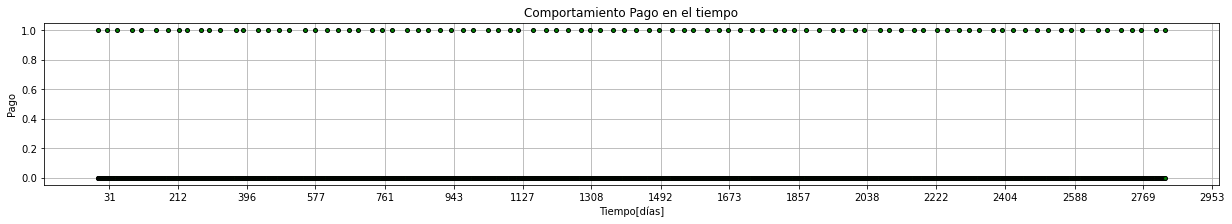

In [9]:
# vector de ceros 
pagos = np.zeros(len(time_product))
#vector de etiqueta de tiempo 
labels_time = np.arange(len(time_product))
# se identifican las fechas de pago dentro del vector de tiempo de vida del producto
for i in range(len(fecha_pago)):
    index_to_replace = np.where(time_product == fecha_pago.iloc[i])
    pagos[index_to_replace] = 1

fig, ax = plt.subplots(figsize=(17, 3), constrained_layout=True)
ax.set(title="Comportamiento Pago en el tiempo")
ax.plot(labels_time, pagos, "ro", color="k", markerfacecolor="g", markersize=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.set_xlabel("Tiempo[días]")
ax.set_ylabel("Pago")
plt.grid(True)

En el orden de hacer la predicción se quiere hacer un forecasting de una serie de tiempo binaria, que me prediga el dia siguiente de pago teniendo en cuenta toda la historia anterior del comportamiento de este producto, respecto del día cero del producto. Para poder hacer testeo se requiere separar los últimos 30 días de pago como conjunto de validación. 

In [10]:
test_size = 30

labels_time_train = labels_time[:-test_size]
pagos_train = pagos[:-test_size]
labels_time_test = labels_time[-test_size:]
pagos_test = pagos[-test_size:]

# Regresión con redes neuronales LSTM (Long Short-Term Memory Network)

Tipo de red neuronal recurrente capaz de recordar la información pasada al predecir valores futuros, este tipo de arquitectura tiene en cuenta la información pasada.


Para iniciar se debe tener en cuenta que en un problema de series temporales se tiene que predecir un valor en el tiempo $t$, basado en los días pasados $tN$ donde $N$ puede ser cualquier número de pasos. Se va a predecir el día de pago. Se van a probar diferentes pasos de tiempos para tratar de construir el mejor modelo posible.

Se crea entonces los conjuntos de datos necesarios para entrenar el modelo. El conjunto de características debe contener los valores 



In [11]:
features_set = list()
labels = list()

Nt = len(pagos_train)- test_size

for i in range(Nt, len(pagos_train)):
    features_set.append(pagos_train[i-Nt:i])
    labels.append(pagos_train[i])

features_set, labels = np.array(features_set), np.array(labels)
features_set.shape

(30, 2769)

Para entrenar la red LSTM a pattir de estos datos, se necesita convertir los datos a una forma que la red Neuronal entienda. Esto es un tensor , un formato de matrices tridimensional. La primera dimensión es el número de registros o filas en el conjunto de datos 

In [12]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape

(30, 2769, 1)

Se han redimensionado los datos, en este momento se propone el modelo LSTM. El modelo que se va a crear es un modelo secuencial con múltiples capas, en principio se agregan cuatro capas LSTM al modelo seguida de una capa densa que predice el día futuro de pago.

In [13]:
model = Sequential()
model.add(LSTM(units=2, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=4, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=6, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=8))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation="sigmoid"))

Ahora se compila el modelo, Se utiliza como función de pérdida el error medio cuadrado

$$ECM = \frac{1}{n}\sum^{n}_{i=1}(\hat{y}_{i}-y_{i})$$


In [14]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])


Ahora es el momento del entrenamiento del modelo que se definió anteriormente. Se hace una prueba para ver que tanto se demora el modelo 

In [15]:
model.fit(features_set, labels, epochs = 10, batch_size = 64)


Epoch 1/10
30/30 [==============================] - 13s 420ms/step - loss: 0.6944 - accuracy: 0.1333
Epoch 2/10
30/30 [==============================] - 9s 296ms/step - loss: 0.6909 - accuracy: 0.9000
Epoch 3/10
30/30 [==============================] - 9s 297ms/step - loss: 0.6868 - accuracy: 1.0000
Epoch 4/10
30/30 [==============================] - 9s 296ms/step - loss: 0.6830 - accuracy: 1.0000
Epoch 5/10
30/30 [==============================] - 9s 297ms/step - loss: 0.6802 - accuracy: 1.0000
Epoch 6/10
30/30 [==============================] - 9s 299ms/step - loss: 0.6755 - accuracy: 1.0000
Epoch 7/10
30/30 [==============================] - 9s 299ms/step - loss: 0.6706 - accuracy: 1.0000
Epoch 8/10
30/30 [==============================] - 9s 299ms/step - loss: 0.6683 - accuracy: 1.0000
Epoch 9/10
30/30 [==============================] - 9s 304ms/step - loss: 0.6639 - accuracy: 1.0000
Epoch 10/10
30/30 [==============================] - 9s 305ms/step - loss: 0.6584 - accuracy: 1.000

Una vez entrenado el modelo LSTM, es el momento de probar el rendimiento de nuestro algoritmo en el conjunto de prueba al predecir los precios de pago en el siguiente mes, es decir, 30 días después del último día registrado en el conjunto de entrenamiento. Para cada día del mes siguiente que queremos predecir se debe tener los 120 días anteriores. Entonces se deben concatenar los datos de validación y de entrenamiento. 

Es importante anotar que para esta etapa de desarrollo se tienen los datos consignados en las variables iniciales de lectura, de otra manera si se tienen datos de testeo independientes se deben concatenar para tener el conjunto de datos completo y poder hacer la preparación adecuadoa para someter al modelo.

Ahora se prepara las entradas al modelo de prueba. La entrada para cada día debe contener los datos de pago de 120 días anteriores y los 30 datos para la predicción, se constuye el vector con estos 150 valores

In [16]:
test_inputs = pagos[len(pagos) - len(pagos_test) - Nt:]
test_inputs = test_inputs.reshape(-1,1)


In [17]:
test_features = list()
for i in range(Nt, Nt+test_size):
    test_features.append(test_inputs[i-Nt:i])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [18]:
predictions = model.predict_proba(test_features)

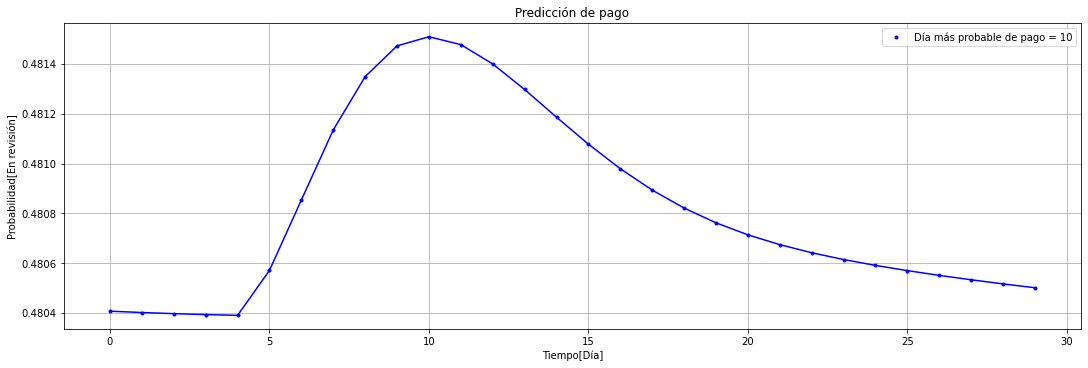

In [19]:
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
plt.plot(predictions, "b-")
plt.plot(predictions, "b.", label = "Día más probable de pago = {}".format(np.argmax(predictions)))
plt.title("Predicción de pago")
plt.xlabel("Tiempo[Día]")
plt.ylabel("Probabilidad[En revisión]")
plt.grid(True)
plt.legend()

In [20]:
labels_time_train

array([   0,    1,    2, ..., 2796, 2797, 2798])

In [21]:
predictions

array([[0.4804072 ],
       [0.4804018 ],
       [0.48039728],
       [0.48039347],
       [0.48039034],
       [0.48057085],
       [0.48085365],
       [0.48113492],
       [0.48134932],
       [0.48147282],
       [0.48150954],
       [0.48147783],
       [0.48140025],
       [0.48129764],
       [0.48118645],
       [0.48107806],
       [0.48097938],
       [0.4808936 ],
       [0.48082152],
       [0.48076218],
       [0.48071384],
       [0.48067445],
       [0.480642  ],
       [0.48061466],
       [0.4805911 ],
       [0.4805701 ],
       [0.48055103],
       [0.48053336],
       [0.48051676],
       [0.48050123]], dtype=float32)